In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -----------------------------
# 1. 데이터 불러오기 & 정렬
# -----------------------------
df = pd.read_csv('upbit_realtime_10s_12h.csv')
df = df.sort_values("timestamp").reset_index(drop=True)

# -----------------------------
# 2. 스케일링
# -----------------------------
features = ["trade_price", "change_rate", "acc_trade_volume"]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
scaled = pd.DataFrame(scaled_features, columns=features)

# -----------------------------
# 3. XGBoost 학습
# -----------------------------
# lag feature 생성
df["lag1"] = df["trade_price"].shift(1)
df["lag5"] = df["trade_price"].shift(6)
df = df.dropna()

X_xgb = df[["lag1", "lag5", "change_rate", "acc_trade_volume"]].values
y_xgb = df["trade_price"].values

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, shuffle=False
)

xgb_model = XGBRegressor(n_estimators=100, max_depth=5)
xgb_model.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_xgb)

rmse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
print(f"XGBoost RMSE (original scale): {rmse_xgb:.4f}")

# -----------------------------
# 4. LSTM 학습
# -----------------------------
def make_sequences(data, window_size=6):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # trade_price 예측
    return np.array(X), np.array(y)

X_lstm, y_lstm = make_sequences(scaled.values, window_size=6)
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

lstm_model = Sequential([
    LSTM(64, activation="tanh", input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32,
               validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# 예측
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)

# -----------------------------
# 5. LSTM 예측값 역변환
# -----------------------------
# trade_price 컬럼만 역변환
y_pred_lstm_full = np.zeros((len(y_pred_lstm_scaled), scaled.shape[1]))
y_pred_lstm_full[:, 0] = y_pred_lstm_scaled[:, 0]
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm_full)[:, 0]

y_test_lstm_full = np.zeros((len(y_test_lstm), scaled.shape[1]))
y_test_lstm_full[:, 0] = y_test_lstm
y_test_lstm_original = scaler.inverse_transform(y_test_lstm_full)[:, 0]

rmse_lstm = mean_squared_error(y_test_lstm_original, y_pred_lstm_original, squared=False)
print(f"LSTM RMSE (original scale): {rmse_lstm:.4f}")


XGBoost RMSE (original scale): 127.7245
Epoch 1/20
532/532 [==============================] - 2s 2ms/step - loss: 0.0692 - val_loss: 0.0053
Epoch 2/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 3/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 4/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 6/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 7/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 8/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/20
532/532 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 10/20
532/532 [==============================] - 1s 2m

=== XGBoost Performance ===
RMSE: 127.7245, MAE: 56.3968, Residual Std: 114.7837

=== LSTM Performance ===
RMSE: 13.1445, MAE: 7.9844, Residual Std: 11.8648


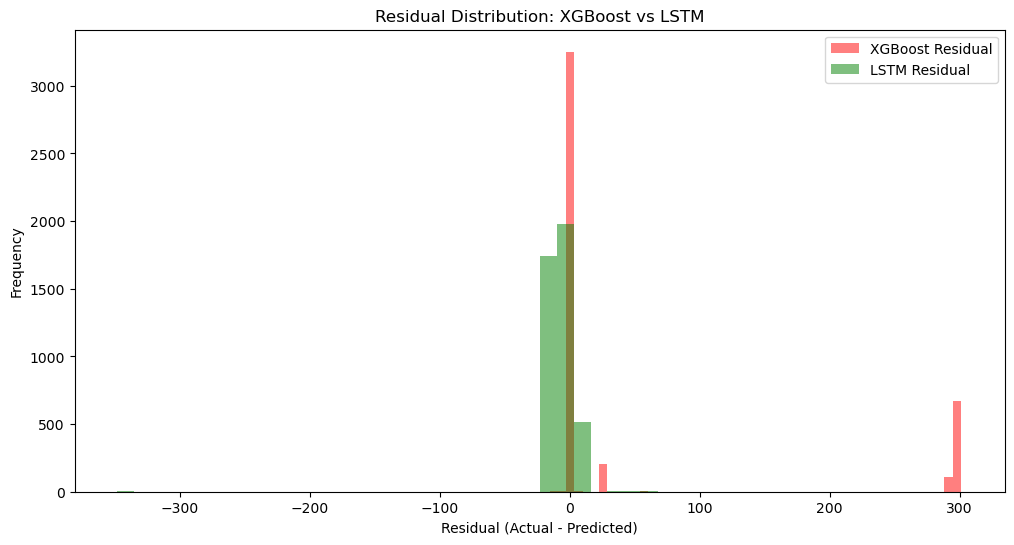

In [3]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 예측값 준비
# XGBoost
y_pred_xgb_plot = y_pred_xgb
y_test_xgb_plot = y_test_xgb

# LSTM
y_pred_lstm_plot = y_pred_lstm_original
y_test_lstm_plot = y_test_lstm_original

# Residual 계산
residual_xgb = y_test_xgb_plot - y_pred_xgb_plot
residual_lstm = y_test_lstm_plot - y_pred_lstm_plot

# RMSE
rmse_xgb = mean_squared_error(y_test_xgb_plot, y_pred_xgb_plot, squared=False)
rmse_lstm = mean_squared_error(y_test_lstm_plot, y_pred_lstm_plot, squared=False)

# MAE
mae_xgb = mean_absolute_error(y_test_xgb_plot, y_pred_xgb_plot)
mae_lstm = mean_absolute_error(y_test_lstm_plot, y_pred_lstm_plot)

# Residual 표준편차
std_xgb = np.std(residual_xgb)
std_lstm = np.std(residual_lstm)

# 결과 출력
print("=== XGBoost Performance ===")
print(f"RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, Residual Std: {std_xgb:.4f}")

print("\n=== LSTM Performance ===")
print(f"RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, Residual Std: {std_lstm:.4f}")

# 히스토그램 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(residual_xgb, bins=50, alpha=0.5, label='XGBoost Residual', color='red')
plt.hist(residual_lstm, bins=50, alpha=0.5, label='LSTM Residual', color='green')
plt.title("Residual Distribution: XGBoost vs LSTM")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
